In [1]:
import pdb
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('fivethirtyeight')
%matplotlib inline

### Read the training data
and see if there are missing values.

In [2]:
train = pd.read_csv('train.csv')
survival_frac = train.Survived.sum() / float(len(train))
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Create one-hot columns for categorical features

In [3]:
# Create dummy variables for Sex
dummies_sex = pd.get_dummies(train['Sex'])
train = pd.concat([train, dummies_sex], axis=1)

# Create dummy variables for Embarked
# There are two passengers with missing info on where they embarked; fill with randomly drawn values
train['Embarked'] = np.where(train['Embarked'].notnull(), train['Embarked'],
                             np.random.choice(train['Embarked'][train['Embarked'].notnull()]))
dummies_emb = pd.get_dummies(train['Embarked'], prefix='emb')
train = pd.concat([train, dummies_emb], axis=1)

# Create dummy variables for Pclass
dummies_pclass = pd.get_dummies(train['Pclass'], prefix='class')
train = pd.concat([train, dummies_pclass], axis=1)
train['class_13'] = np.logical_or(train['class_1'], train['class_3']).astype('int')

# Create dummy variable for cabins
train['cabin_letter'] = train['Cabin'].map(lambda x: x[0] if pd.notnull(x) else 'X')
dummies_cabin = pd.get_dummies(train['cabin_letter'], prefix='cabin')
train = pd.concat([train, dummies_cabin], axis=1)
train['cabin_BDE'] = train['cabin_letter'].isin(['B', 'D', 'E']).astype('int')
train['cabin_BCDE'] = train['cabin_letter'].isin(['B', 'C', 'D', 'E']).astype('int')

train['Family'] = np.logical_or(train['SibSp'], train['Parch']).astype('int')
train['FamilyMembers'] = train['SibSp'] + train['Parch']
train['Child'] = (train['Age'] < 15).astype('int')  # define passengers younger than 15 yrs old as Child
train['female'][train['Age'] < 15] == 0
train['male'][train['Age'] < 15] == 0

# Try to impute missing passenger age: randomly draw from the available values of age
train['Age'] = np.log1p(train['Age'])   # log-transform passenger age
age_random = np.random.choice(train['Age'][train['Age'].notnull()].values, size=len(train))
train['Age'] = np.where(train['Age'].notnull(), train['Age'], age_random)

# Also log-transform ticket fare
train['Fare'] = np.log1p(train['Fare'])

Look at the age distribution; the distribution in log space is more or less Gaussian, with some outliers on the low end of the distribution.

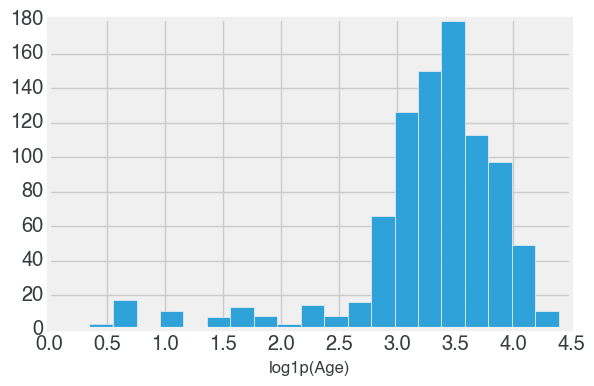

In [4]:
h = plt.hist(train['Age'], bins=20)
plt.xlabel('log1p(Age)')

### Explore correlations of variables with survival

In [5]:
columns = ['Age', 'SibSp', 'Parch', 'Fare', 'female', 'male', 'Child',
           'emb_C', 'emb_Q', 'emb_S', 'class_1', 'class_2', 'class_3',
           'Family', 'Survived', 'cabin_A', 'cabin_B', 'cabin_C',
           'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T',
           'cabin_X', 'FamilyMembers',
           'cabin_BCDE', 'cabin_BDE', 'class_13']
corr = train[columns].corr()

Showing the absolute values of correlation coefficients, capping at 0.5.

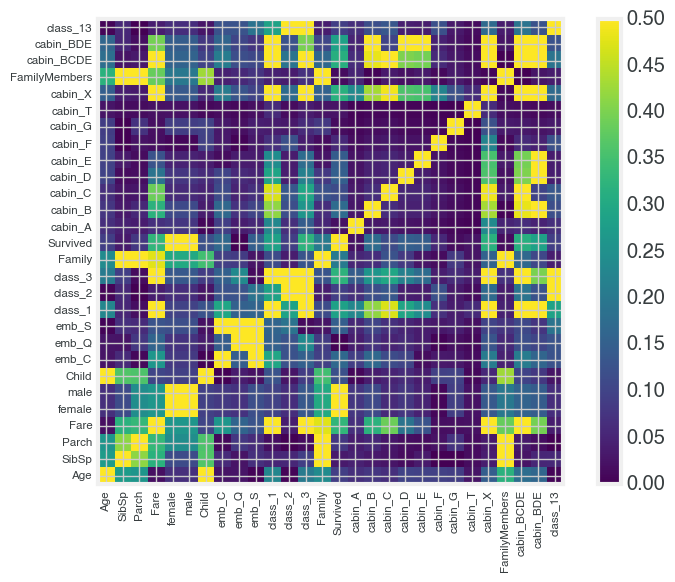

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(corr.abs().values, vmin=0, vmax=0.5)
t = plt.xticks(np.arange(len(corr)), corr.index, size='small', rotation=90)
t = plt.yticks(np.arange(len(corr)), corr.columns, size='small')
plt.colorbar()

Investigate the fare distribution of passengers; my hypothesis is that higher fares have higher survival rates.

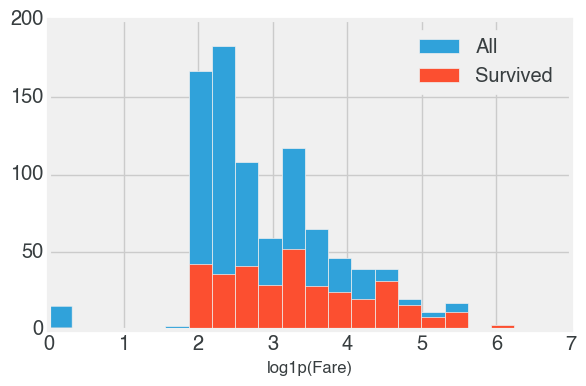

In [7]:
h = plt.hist(train['Fare'], bins=20, label='All')
h = plt.hist(train['Fare'][train['Survived']==1], bins=h[1], label='Survived')
plt.xlabel('log1p(Fare)')
plt.legend(loc=0)

Could there be some cabins with higher survival rates?
Missing cabins will be assigned to "X".

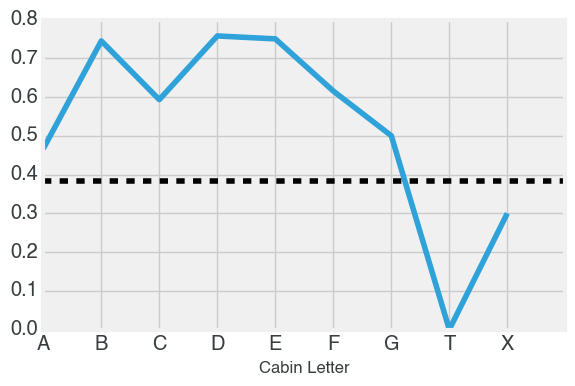

In [8]:
survived = (train['Survived'] == 1)
labels = train['cabin_letter'].unique()
s1 = train[survived]['cabin_letter'].value_counts() + pd.Series(0, index=labels)
s2 = train[~survived]['cabin_letter'].value_counts() + pd.Series(0, index=labels)
s1 = s1.fillna(0)
s2 = s2.fillna(0)
x = plt.plot(np.arange(len(s1)), s1 / (s1 + s2))
x = plt.xticks(np.arange(len(s1)), s1.index)
x = plt.plot([0, len(s1)], [survival_frac, survival_frac], ls='--', c='black', label='Average')
plt.xlabel('Cabin Letter')

Decide on which features to use for learning, and process the test data in the same way.

In [9]:
### Use these features
features = ['Child', 'emb_C', 'emb_S', 'FamilyMembers', 'class_1', 'class_3',
            'female', 'cabin_X', 'cabin_BDE']
x_train = preprocessing.scale(train[features])
y_train = train['Survived']

# Read test data and calculate all the necessary columns
test = pd.read_csv('test.csv')
print("Are there any missing values in the test data?\n", test.isnull().sum())
test['Child'] = (test['Age'] < 15.).astype('int')
test['Family'] = np.logical_or(test['SibSp'], test['Parch']).astype('int')
test['FamilyMembers'] = test['SibSp'] + test['Parch']
dummy_sex = pd.get_dummies(test['Sex'])
test = pd.concat([test, dummy_sex], axis=1)
dummy_emb = pd.get_dummies(test['Embarked'], prefix='emb')
test = pd.concat([test, dummy_emb], axis=1)
dummy_class = pd.get_dummies(test['Pclass'], prefix='class')
test = pd.concat([test, dummy_class], axis=1)
test['cabin_letter'] = test['Cabin'].map(lambda x: x[0] if pd.notnull(x) else 'X')
dummies_cabin = pd.get_dummies(test['cabin_letter'], prefix='cabin')
test = pd.concat([test, dummies_cabin], axis=1)
test['cabin_BCDE'] = test['cabin_letter'].isin(['B', 'C', 'D', 'E']).astype('int')
test['cabin_BDE'] = test['cabin_letter'].isin(['B', 'D', 'E']).astype('int')
test['logFare'] = np.log10(test['Fare'] + 1)
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test['logFare'] = test['logFare'].fillna(test['logFare'].mean())
test['Age'] = np.where(test['Age'].notnull(), test['Age'],
                      np.random.choice(test['Age'][test['Age'].notnull()], size=len(test)))
test['logAge'] = np.log10(test['Age'])

x_test = preprocessing.scale(test[features])

Are there any missing values in the test data?
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Apply ML algorithms
I experimented with a few models, and decided on the extra trees classifier.

In [10]:
# clf = RandomForestClassifier(n_estimators=100)
# clf = RandomForestClassifier(n_estimators=200, n_jobs=2, max_depth=5, max_features='log2')
# clf = GradientBoostingClassifier(n_estimators=200)
# clf = AdaBoostClassifier(n_estimators=200)
clf = ExtraTreesClassifier(n_estimators=200, n_jobs=2, max_features='log2',
                          max_depth=6)

# Calculate the cross validation score
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("CV score for \n{}: \n{:.3f} +/- {:.3f}".format(clf, scores.mean(), scores.std()))
# Write down some of the CV scores:
# Logistic regression: 0.800
# KNN: 0.808
# Linear SVC: 0.793
# Random forest (100 estimators): 0.817
# Random forest (200 estimators): 0.819
# Gradient Boosting (200 estimators): 0.815
# AdaBoost (200 estimators): 0.790
# Extra Trees (200 estimators): 0.829 (after GridSearchCV)

CV score for 
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=6, max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False): 
0.825 +/- 0.016


#### Let's do an exhaustive search of the hyperparameters of Extra Trees Classifier

In [12]:
clf = ExtraTreesClassifier()
param_grid = [{'n_estimators': [100, 200, 500, 1000], 'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'log2'], 'max_depth':[5, 6, 7]}]
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=2, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'max_depth': [5, 6, 7], 'max_features': ['auto', 'log2'], 'n_estimators': [100, 200, 500, 1000], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
scores = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']
ind = np.argsort(scores)[::-1]
for i in ind[:10]:
    print(params[i], "{:.4f}".format(scores[i]))

{'max_depth': 6, 'criterion': 'entropy', 'n_estimators': 500, 'max_features': 'auto'} 0.8305
{'max_depth': 6, 'criterion': 'gini', 'n_estimators': 500, 'max_features': 'auto'} 0.8283
{'max_depth': 6, 'criterion': 'entropy', 'n_estimators': 100, 'max_features': 'auto'} 0.8283
{'max_depth': 6, 'criterion': 'gini', 'n_estimators': 200, 'max_features': 'log2'} 0.8283
{'max_depth': 6, 'criterion': 'gini', 'n_estimators': 1000, 'max_features': 'log2'} 0.8272
{'max_depth': 6, 'criterion': 'entropy', 'n_estimators': 1000, 'max_features': 'log2'} 0.8272
{'max_depth': 6, 'criterion': 'gini', 'n_estimators': 100, 'max_features': 'log2'} 0.8260
{'max_depth': 6, 'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'auto'} 0.8260
{'max_depth': 5, 'criterion': 'gini', 'n_estimators': 200, 'max_features': 'auto'} 0.8249
{'max_depth': 5, 'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'log2'} 0.8249


#### Let's do an exhaustive search of the hyperparameters of Random Forest Classifier

In [493]:
clf = RandomForestClassifier()
param_grid = [{'n_estimators': [100, 200, 500, 1000], 'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'log2'], 'max_depth':[5, 6, 7]}]
grid2 = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=2, cv=5)
grid2.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7], 'max_features': ['auto', 'log2'], 'n_estimators': [100, 200, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [494]:
scores = grid2.cv_results_['mean_test_score']
params = grid2.cv_results_['params']
ind = np.argsort(scores)[::-1]
for i in ind[:10]:
    print(params[i], "{:.4f}".format(scores[i]))

{'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'log2', 'max_depth': 5} 0.8283
{'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'auto', 'max_depth': 5} 0.8249
{'criterion': 'entropy', 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 6} 0.8238
{'criterion': 'gini', 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5} 0.8238
{'criterion': 'gini', 'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 5} 0.8227
{'criterion': 'entropy', 'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 5} 0.8227
{'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'log2', 'max_depth': 6} 0.8227
{'criterion': 'gini', 'n_estimators': 100, 'max_features': 'auto', 'max_depth': 5} 0.8227
{'criterion': 'entropy', 'n_estimators': 200, 'max_features': 'auto', 'max_depth': 7} 0.8215
{'criterion': 'gini', 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 6} 0.8215


### Make predictions and write a submission file

In [26]:
clf = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_features='log2',
                          max_depth=6)
X = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
output = test[['PassengerId']]
output = output.assign(Survived=pd.Series(y_pred))
output.to_csv('titanic_forest_sub38.csv', header=True, index=False)